In [ ]:
import os
import torch
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sentence_transformers.evaluation import EmbeddingSimilarityEvaluator

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'{device} loaded. There are {torch.cuda.device_count()} GPU(s) available.')

cuda loaded. There are 1 GPU(s) available.


In [3]:
def load_taxon_dataset(dataset, filter_taxon_fp=None, seed=23):
    print(f"Loading descriptors from {dataset}")
    
    df_ip = load_dataset("imageomics/char-sim-data", dataset, split='train').to_pandas()
    
    df_ip['simGIC'] = df_ip['simGIC']/100.0 # normalize similarity score values (per the max SimGIC value)
    df_ip['simGIC'] = (df_ip['simGIC']*2)-1  # to match cos_similarity range

    # Get unique character IDs
    ch1_ids = df_ip['character_1'].unique()
    ch2_ids = df_ip['character_2'].unique()
    ch_ids = np.union1d(ch1_ids, ch2_ids)

    #Filter out characters from reference taxon
    if filter_taxon_fp is not None:
        print(f"Removing {filter_taxon_fp} characters from {dataset}")
        taxon_df_ip = load_dataset("imageomics/char-sim-data", filter_taxon_fp, split='train').to_pandas()
        taxon_ch_ids = np.union1d(taxon_df_ip['character_1'].unique(), taxon_df_ip['character_2'].unique())
        ch_ids = np.setdiff1d(ch_ids, taxon_ch_ids)

    #Create evaluation dataframe
    eval_df = df_ip[df_ip['character_1'].isin(ch_ids) & df_ip['character_2'].isin(ch_ids)][['desc_1', 'desc_2', 'simGIC']]
    eval_df.columns = ['sentence1', 'sentence2', 'score']
    eval_df.reset_index(drop = True, inplace = True)
    eval_df['sentence1'] = eval_df['sentence1'].astype("string")
    eval_df['sentence2'] = eval_df['sentence2'].astype("string")

    return eval_df


#### Note
Make sure you have a pre-trained model on the characiformes dataset. Please see README.md for more details.

In [ ]:
#PARAMETERS
SEED=23 #Random seed for reproducibility
MODEL_PATH = os.path.join("..", "outputs", "characiformes", "model") #Path to pre-trained model
DS_NAMES = ['siluriformes', 'cypriniformes', 'gymnotiformes'] #List of taxa to evaluate
NUM_BOOTSTRAP_SAMPLES = 30 #Number of bootstrap samples to estimate confidence intervals
MAX_NUM_SAMPLES = 200 #Maximum number of samples from each evaluation dataset
FILTER_TAXON = "characiformes" #Taxon to filter from evaluation datasets

In [5]:
#Load pre-trained model
model = SentenceTransformer(MODEL_PATH)

In [6]:
#Load dataframes corresponding to each taxon in DS_NAMES
df_list = [load_taxon_dataset(ds, FILTER_TAXON) for ds in DS_NAMES]

Loading descriptors from siluriformes
Removing characiformes characters from siluriformes
Loading descriptors from cypriniformes
Removing characiformes characters from cypriniformes
Loading descriptors from gymnotiformes
Removing characiformes characters from gymnotiformes


In [7]:
#Compute evaluation results.
results = []
for i in range(NUM_BOOTSTRAP_SAMPLES):
    for ds, df_fp in zip(DS_NAMES, df_list):
        df = df_fp.sample(n=MAX_NUM_SAMPLES, replace=True, random_state=i+SEED)

        test_evaluator = EmbeddingSimilarityEvaluator(
            sentences1=df["sentence1"].to_numpy(),
            sentences2=df["sentence2"].to_numpy(), 
            scores=df["score"].to_numpy(),
            show_progress_bar = True,
            write_csv=True,
            name=f""
        )
        result = test_evaluator(model)
        result.update({"taxon":ds.capitalize()})
        results += [result]

Batches: 100%|██████████| 13/13 [00:02<00:00,  5.39it/s]


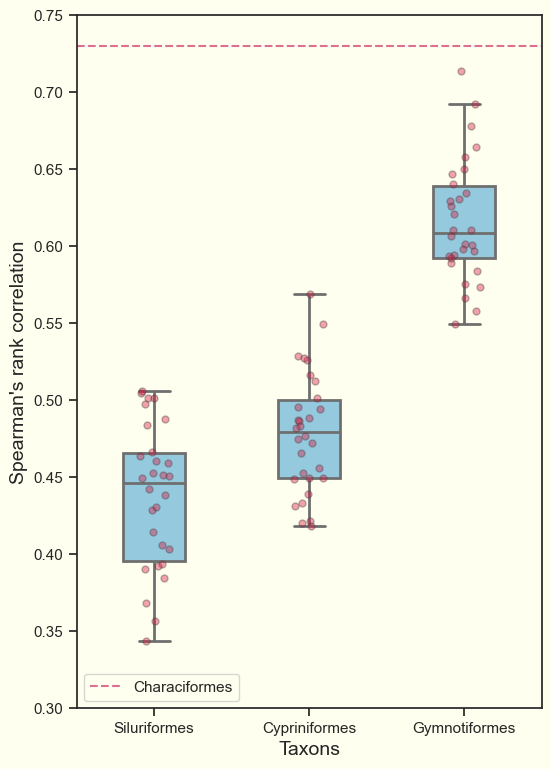

In [8]:
results_df = pd.DataFrame.from_records(results)

sns.set_theme(style="ticks",                   
                rc={"figure.figsize": (6, 9),      
                    "figure.facecolor": "ivory",  
                    "axes.facecolor": "ivory"})  
# Box plot
b = sns.boxplot(data = results_df,           
                    x = "taxon",       
                    y = "spearman_cosine",      
                    width = 0.4,        
                    color = "skyblue",  
                    linewidth = 2,      
                    showfliers = False)  
# Strip plot
b = sns.stripplot(data = results_df,          
                      x = "taxon",      
                      y = "spearman_cosine",      
                      color = "crimson", 
                      linewidth = 1,     
                      alpha = 0.4)       

b.set_ylabel("Spearman's rank correlation", fontsize = 14)
b.set_xlabel("Taxons", fontsize = 14)
b.get_figure()

plt.axhline(0.73, ls='--', color='palevioletred', label="Characiformes")
plt.legend()
plt.ylim(.3, .75)
plt.show()